In [91]:
import numpy as np
import itertools as it
from collections import OrderedDict as ordict

In [121]:
def get_random_jpt(nvar, nval):
  jpt = np.random.rand(nval ** nvar)
  jpt /= jpt.sum()
  return jpt

def get_cpt(jpt, predvars, nvar, nval):
  condvars = np.ones((nvar,), dtype=bool)
  condvars[predvars] = 0
  predvars = ~condvars # but we can rely on predvars being a boolean mask

  cpt = np.nan * np.zeros((jpt.size, jpt.size), dtype=np.float32)
  for i, condstate in zip(range(jpt.size), it.product(range(nval), repeat=nvar)):
    for j, predstate in zip(range(jpt.size), it.product(range(nval), repeat=nvar)):
      # p(y_a, y_b | x_a, x_b) = p(y_a, y_b | x_b) = p(y_a, y_b, x_b) / p(x_b)
      # we have p(y_b != x_b) = 0.  for y_b = x_b, p(y_a, y_b, x_b) / p(x_b) = p(y_a, x_b) / p(x_b)
      # and we can do the normalization by p(x_b) after filling the cpt
      condition_changed = not np.equal(condstate, predstate)[condvars].all()
      joint_index = np.ravel_multi_index(np.where(predvars, predstate, condstate), (nval,) * nvar)
      cpt[i, j] = 0 if condition_changed else jpt[joint_index]

  # normalize
  cpt /= cpt.sum(axis=1, keepdims=True)
  return cpt

In [158]:
def get_intersecting_models():
  nvar, nval = 2, 2
  low, high = 0.001, 1.0
  jpt = low + np.zeros((nval,) * nvar)
  assert nvar == 2
  # two models that overlap in corners furthest away from main diagonal
  jpt[0,  :] = high
  jpt[:, -1] = high
  jpts = [jpt, jpt.T]
  jpts = [jpt.flatten() / jpt.sum() for jpt in jpts]
  return jpts

def get_random_jpt(nvar, nval):
  jpt = np.random.rand(nval ** nvar)
  jpt /= jpt.sum()
  return jpt

def get_halfspace_jpts(nvar, nval):
  low, high = 0.001, 1.0
  jpts = []
  for i in range(nvar):
    jpt = low + np.zeros((nval,) * nvar)
    jpt[(slice(None),) * i + (slice(0, nval // 2),)] = high
    jpt /= jpt.sum()
    jpts.append(jpt.flatten())
  return jpts

In [159]:
nvar = 2
nval = 8
nmodel = 6
#models = [get_random_jpt(nvar=nvar, nval=nval) for _ in range(nmodel)]
models = get_halfspace_jpts(nvar=nvar, nval=nval)

# run free full gibbs
v = get_random_jpt(nvar=nvar, nval=nval)
print(v)
vs = [v]
for _ in range(1000):
  model = models[np.random.choice(len(models))]
  predvars = np.random.randint(nvar)
  v = np.dot(v, get_cpt(model, predvars, nvar=nvar, nval=nval))
  print(v)
  vs.append(v)
vs = np.asarray(vs)

[ 0.01804489  0.02262636  0.02932101  0.02947912  0.00030181  0.01089645
  0.01712292  0.01039756  0.02863225  0.01370804  0.00655907  0.01508889
  0.020263    0.01690445  0.01700234  0.00543754  0.02403846  0.02572323
  0.01480718  0.00630493  0.00083995  0.01025139  0.00383286  0.02649509
  0.029837    0.01023579  0.01088743  0.00029691  0.01363092  0.02886873
  0.02888383  0.01362408  0.00681197  0.0135123   0.0218831   0.01328547
  0.0149413   0.01698979  0.02624131  0.01374373  0.00490539  0.00033834
  0.00325728  0.00337556  0.0227264   0.0223942   0.02523766  0.02462624
  0.03151894  0.01378784  0.02826739  0.01109899  0.02527168  0.00228674
  0.00074118  0.0007297   0.02587918  0.00899122  0.0137973   0.02034201
  0.02796412  0.01984823  0.00388879  0.02097315]
[ 0.02120851  0.01361539  0.01609747  0.01240899  0.0157424   0.016055
  0.01536886  0.01450339  0.02120851  0.01361539  0.01609747  0.01240899
  0.0157424   0.016055    0.01536886  0.01450339  0.02120851  0.01361539
  0

In [160]:
distributions = ordict()

for i, model in enumerate(models):
  distributions["model%i" % i] = model

expected_transition = np.mean([get_cpt(model, predvar, nvar=nvar, nval=nval) for model in models for predvar in range(nvar)], axis=0)
evals, evecs = np.linalg.eig(expected_transition.T)
assert np.allclose(0, np.imag(evecs[:, 0]))
distributions["theoretical"] = np.real(evecs[:, 0])

# in some cases there are multiple stationary distributions, i.e. multiple ergodic subspaces to get stuck in.
# I thought if I combined all the eigenvectors with weights given by the eigenvalues, I'd get an "expected"
# stationary distribution, but alas the resulting distribution has negative probabilities :-|
#distributions["theoretical_all"] = np.dot(evecs, evals)
#assert np.allclose(0, np.imag(distributions["theoretical_all"]))
#distributions["theoretical_all"] = np.real(distributions["theoretical_all"])

distributions["empirical"] = np.mean(vs, axis=0)

# locked transition is more like our case, but not clear how to do if the number of variables doesn't match the number of models
#assert nvar == len(models)
#expected_locked_transition = np.mean([get_cpt(model, predvar) for model, predvar in zip(models, range(nvar))], axis=0)
#evals, evecs = np.linalg.eig(expected_locked_transition.T)
#assert np.allclose(0, np.imag(evecs[:, 0]))
#distributions["theoretical_locked"] = np.real(evecs[:, 0])

distributions["product"] = np.prod(models, axis=0)
distributions["geomean"] = np.prod(models, axis=0) ** (1. / len(models))
distributions["mixture"] = np.mean(models, axis=0)

for dist in distributions.values():
  dist /= dist.sum()

In [161]:
%matplotlib notebook
import matplotlib
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


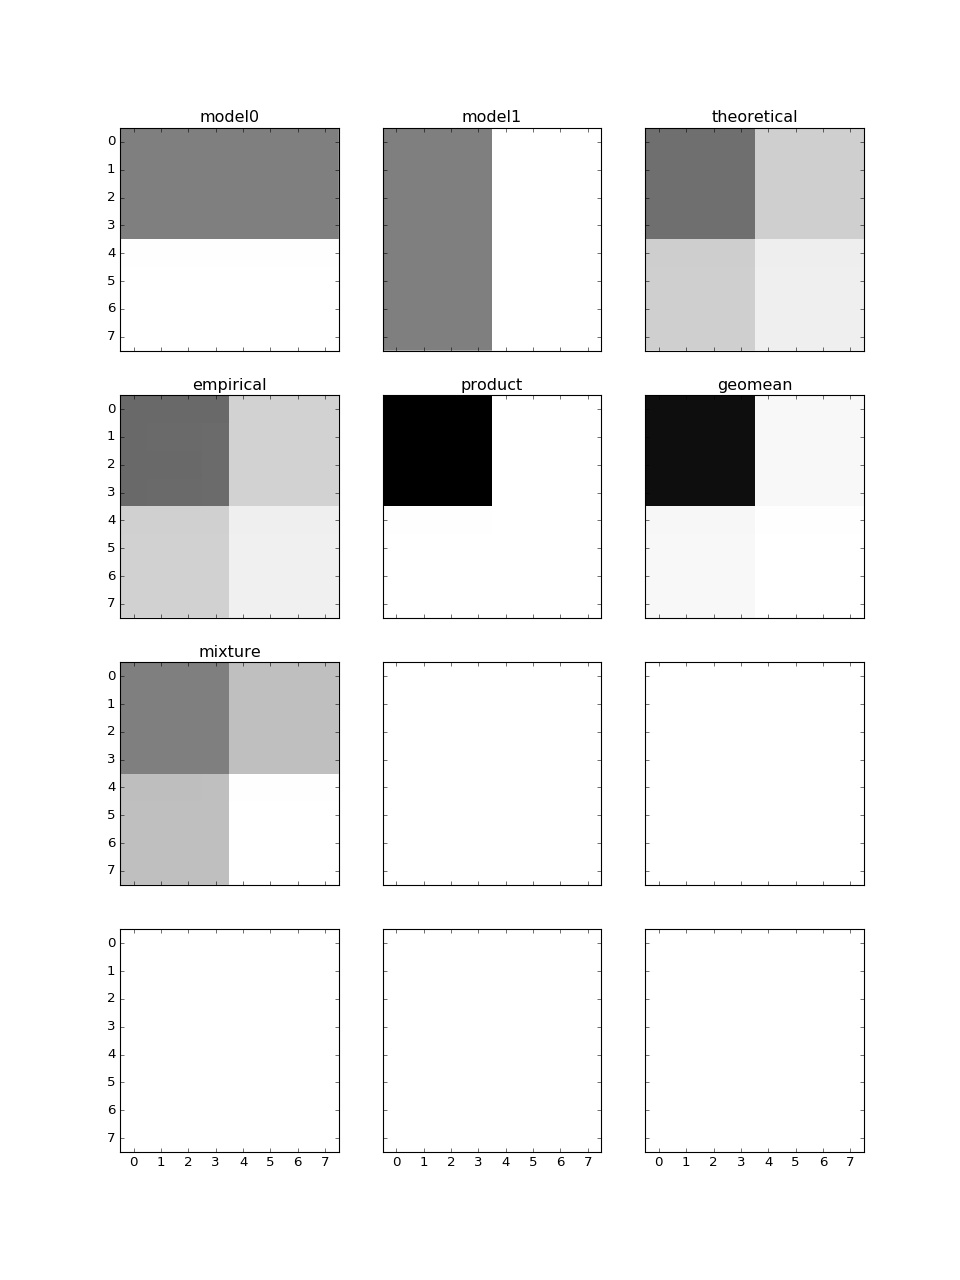

<IPython.core.display.Javascript object>


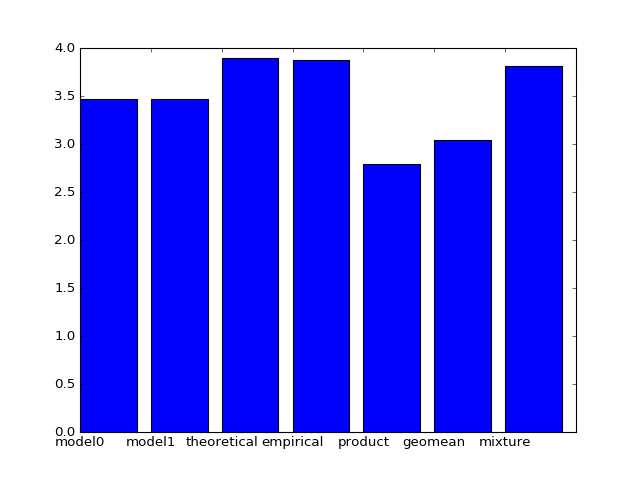

('model0', 'entropy', 3.4736362575573669)
('model1', 'entropy', 3.4736362575573683)
('theoretical', 'entropy', 3.8983552)
('empirical', 'entropy', 3.8729634346869677)
('product', 'entropy', 2.7883894317550637)
('geomean', 'entropy', 3.0466012627392782)
('mixture', 'entropy', 3.8162596704585194)
('entropies', [3.4736362575573669, 3.4736362575573683, 3.8983552, 3.8729634346869677, 2.7883894317550637, 3.0466012627392782, 3.8162596704585194])


<IPython.core.display.Javascript object>


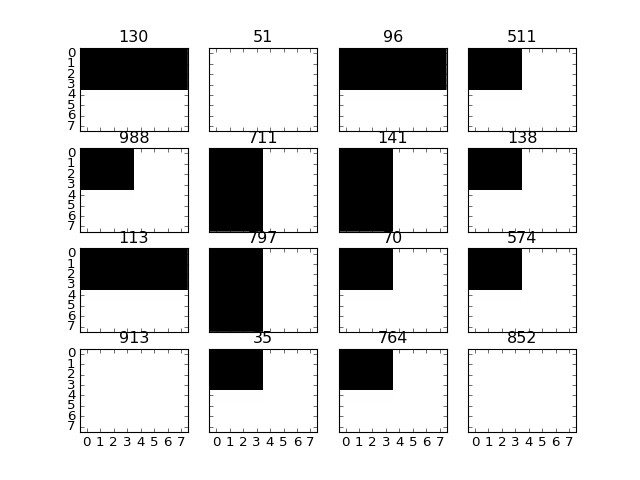

In [162]:
plt.close("all")

assert nvar == 2
matrix_shape = (nval,) * nvar

sigh = dict(cmap="gray_r", aspect="auto", interpolation="none")

vmin, vmax = min(d.min() for d in distributions.values()), max(d.max() for d in distributions.values())
m, n = 4, 3
assert len(distributions) <= m * n
fig, axes = plt.subplots(m, n, sharex=True, sharey=True, figsize=(4 * n, 4 * m))
for (title, dist), ax in zip(distributions.items(), axes.flatten()):
  ax.imshow(dist.reshape(matrix_shape), vmin=vmin, vmax=vmax, **sigh)
  ax.set_title(title)

plt.figure()
for title, dist in distributions.items():
  print(title, "entropy", -np.dot(dist, np.log(dist)))
entropies = [-np.dot(dist, np.log(dist)) for dist in distributions.values()]
print("entropies", entropies)
plt.bar(np.arange(len(entropies)), entropies)
plt.xticks(np.arange(len(entropies)), list(distributions.keys()))

m, n = 4, 4
choice = np.random.choice(len(vs), size=m * n, replace=False)
np.sort(choice, axis=0)

vmin, vmax = min(d.min() for d in vs[choice]), max(d.max() for d in vs[choice])
fig, axes = plt.subplots(m, n, sharex=True, sharey=True)
for i, model, ax in zip(choice, vs[choice], np.ravel(axes)):
  ax.imshow(model.reshape(matrix_shape), **sigh)
  ax.set_title(str(i))

plt.show()